# Neural integration for constitutive equations 

### Benchmark #1: elasto-plastic material

Authors: Filippo Masi, Itai Einav

### 1. Import libraries

In [1]:
import pickle
import numpy as np
import torch
from scipy.optimize import root
from torchdiffeq import odeint
from nice_module import NICE_reduced, EarlyStopping, slice_data, get_params

np.random.seed(6)
torch.manual_seed(6)

# plotting
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('classic')
plt.rcParams.update({"axes.grid" : False, "grid.color": 'black', "grid.alpha":0.4})
font = {'size'   : 11}
matplotlib.rc('font', **font)
plt.rcParams['axes.facecolor']='none'
plt.rcParams['savefig.facecolor']='none'
plt.rcParams['figure.facecolor']='none'
plt.rcParams["figure.figsize"] = (2.5,2)
plt.tight_layout(pad=2.5, w_pad=3.5, h_pad=3.5)
colorb = (0.2,0.4,0.7)

<Figure size 200x160 with 0 Axes>

#### 1.1 Set hyperparameters

In [2]:
# Setting the frequency in epochs for printing loss during training
verbose_frequency = 10

# Step size for the training process. If set to 20, it reproduces the original results
# otherwise, set to 1 for faster training.
step_size = 20

# Checking for GPU availability and assigning the device accordingly
device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')

# Boolean flag for adding normally distributed noise to the training dataset
corrupted_training_data = False

# If corrupted_training_data is True, set the noise amplitude (percentage)
delta = 0.  # Noise amplitude (percentage) if corrupted_training_data is True

### 2. Import and prepare data sets

In [3]:
# File path for the training dataset
file = './dataset/benchmark1_data_training'

# Loading data from the specified file using pickle
with open(file, 'rb') as f_obj:
    data = pickle.load(f_obj)

# Unpacking data into individual variables
[strain_t,strain_tdt,stress_t,dt,n_reset] = data

# Setting batch_time equal to n_reset
batch_time = n_reset

# Setting data_size equal to n_reset
data_size = n_reset

# Dimensionality of the data
dim = 2

# Setting prm_dt as the reciprocal of data_size
prm_dt = 1 / data_size

#### 3.1 Reshape 


In [4]:
dstrain = strain_tdt - strain_t
dstrain/=prm_dt

strain_t = np.reshape(strain_t,(batch_time,-1,dim),order='F')
strain_tdt = np.reshape(strain_tdt,(batch_time,-1,dim),order='F')
dstrain = np.reshape(dstrain,(batch_time,-1,dim),order='F')

stress_t = np.reshape(stress_t,(batch_time,-1,dim),order='F')

data_size = strain_t.shape[0]
number_IC = strain_t.shape[1]

#### 3.2 Split data in training, validation, and test sets 

In [5]:
# Percentage of data to be used for training
train_percentage = 0.65

# Calculating the number of samples for training, validation, and testing
train = int(round(number_IC * train_percentage))
val = int(round(number_IC * 0.5 * (1. - train_percentage)))
test = val

# Printing information about the data split
print("Number of samples: ", number_IC)
print("Training samples: ", train)
print("Validation samples: ", val)
print("Test samples: ", test)
print("Total: ", test + val + train)

Number of samples:  24
Training samples:  16
Validation samples:  4
Test samples:  4
Total:  24


In [6]:
# Creating an array of sequential numbers from 0 to number_IC - 1
n = np.arange(0, number_IC, 1)

# Creating an array of indices and shuffling it
rnd = np.arange(len(n))
np.random.shuffle(rnd)
n = n[rnd]

# Splitting the shuffled indices into training, validation, and test sets
ntrain = n[:train]
cut = len(ntrain)
nval = n[train:]
ntrainval = np.hstack((ntrain, nval))
ntest = n[train + val:]

# Shuffling the indices for training and validation combined set
rnd = np.arange(len(ntrainval))
np.random.shuffle(rnd)

# Splitting the shuffled indices for training and validation sets
ntrain = rnd[:train]
nval = rnd[val:]

In [7]:
# Slicing the strain data into training-validation and test sets
strain_t_tv, strain_t_test = slice_data(strain_t, ntrainval, ntest)

# Slicing the time derivative of strain data into training-validation and test sets
strain_tdt_tv, strain_tdt_test = slice_data(strain_tdt, ntrainval, ntest)

# Slicing the incremental strain data into training-validation and test sets
dstrain_tv, dstrain_test = slice_data(dstrain, ntrainval, ntest)

# Slicing the stress data into training-validation and test sets
stress_t_tv, stress_t_test = slice_data(stress_t, ntrainval, ntest)

In [8]:
# Checking if training data needs to be corrupted with noise
if corrupted_training_data:

    # Generating a stress noise vector
    noise = delta/100 * np.random.normal(0, 1, ((data_size+1, number_IC, dim)))
    
    # Copying the stress data to apply noise
    noise_stress_t = stress_t_tv.copy()
    
    # Adding noise to the stress data
    noise_stress_t[:, :, 0] = np.mean(stress_t_tv[:, :, 0]) * noise[:-1, :, 0]
    noise_stress_t[:, :, 1] = np.mean(stress_t_tv[:, :, 1]) * noise[:-1, :, 1]
    
    # Setting the initial time step to zero
    noise_stress_t[0] *= 0.0
    
    # Adding the noise to the original stress data
    stress_t_tv += noise_stress_t

In [9]:
prm_e = get_params(strain_t_tv).to(device)
prm_de = get_params(dstrain_tv).to(device)
prm_s = get_params(stress_t_tv).to(device)

### 4. Neural integration for constitutive equations

#### 4.1 Constructu neural net and set integration scheme

In [10]:
dtype=torch.float64
NNf_params = [2*dim,dim,[6*(2*dim),6*(2*dim),6*(2*dim),],'gelu']
NNu_params = [2,1,[2**6,2**6],'softplus']
norm_params = [prm_e,prm_de,prm_s,prm_dt]
nsvars = 1
number_IC = len(ntrainval)
NICE_network = NICE_reduced(NNf_params,NNu_params,number_IC,norm_params,dim,dtype).to(device)
NICE_network.to(torch.double)

NICE_reduced(
  (NeuralNetEvolution): Sequential(
    (0): Linear(in_features=4, out_features=24, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=24, out_features=24, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=24, out_features=24, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=24, out_features=2, bias=True)
  )
  (NeuralNetEnergy): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
  (relu): ReLU()
)

In [11]:
# Calculating the time step for the simulation
prm_dt = 1 / data_size

# Creating a time array from 0 to 1 with the calculated time step
t = torch.arange(0, 1.0, prm_dt)

# Converting stress and incremental strain data to torch tensors and moving them to the specified device
stress_tv = torch.from_numpy(np.float64(stress_t_tv)).to(device)
dstrain_tv = torch.from_numpy(np.float64(dstrain_tv)).to(device)

# Converting test set stress and incremental strain data to torch tensors and moving them to the specified device
stress_test = torch.from_numpy(np.float64(stress_t_test)).to(device)
dstrain_test = torch.from_numpy(np.float64(dstrain_test)).to(device)

In [12]:
# Setting the solver type for the NICE network
NICE_network.solver = "midpoint"

# Setting the integration scheme for the NICE network
NICE_network.scheme = "forward"

# Setting the step size for the integration in the NICE network
NICE_network.step_size = prm_dt / step_size

# Initializing the interpolation function for incremental strain and time in the NICE network
NICE_network.init_interp(dstrain_tv, t)

# Turning off the inference mode in the NICE network
NICE_network.inference = False

#### 4.2 Training

In [13]:
# Setting the learning rate for the optimizer
learningRate = 1e-2

# Initializing the Adam optimizer with the NICE network parameters
optimizer = torch.optim.Adam(NICE_network.parameters(), lr=learningRate)

# Setting up a learning rate scheduler to adjust the learning rate during training
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)

# L2 penalty weight for regularization
w_reg = 1.e-5

# Number of training epochs
Nepochs = 1000000

# Mean Squared Error (MSE) loss function
MSE = torch.nn.MSELoss()

# Setting up early stopping with specified criteria
checkpoint_path = './checkpoints/checkpoint.pt'
early_stopping = EarlyStopping(patience=2000, delta=1.e-9, verbose=False, path=checkpoint_path)

# Lists for storing training and validation loss history
training_loss_hist = []
validation_loss_value_hist = []

In [14]:
# Training loop
for epoch in range(1, Nepochs):
    # Reset gradients
    optimizer.zero_grad()

    # Compute the residual of the initial stress value based on the initial elastic strain value (hyperparameter)
    ueps_e_0 = NICE_network.DeNormalize(NICE_network.e0, NICE_network.prm_ee)
    stress0 = NICE_network.stress(ueps_e_0)

    # Make predictions
    pred_svars, pred_stress, pred_diss = NICE_network.integrate(dstrain_tv, ueps_e_0, t, np.hstack((ntrain, nval)))

    # Compute training loss
    training_loss_stress = MSE(NICE_network.Normalize(pred_stress[:, ntrain], prm_s),
                               NICE_network.Normalize(stress_tv[:, ntrain], prm_s))
    training_loss_r0 = MSE(NICE_network.Normalize(stress0, prm_s),
                           NICE_network.Normalize(stress_tv[0], prm_s))
    norm_d = torch.max(torch.abs(pred_diss)).detach()
    training_loss_dissipation = MSE(NICE_network.relu(-pred_diss[:, ntrain]) / norm_d,
                                    pred_diss[:, ntrain].detach() * 0)

    # L2 regularization term
    l_reg = torch.tensor(0., requires_grad=True)
    for name, param in NICE_network.named_parameters():
        if 'weight' in name:
            l_reg = l_reg + pow(param, 2).sum()

    # Compute the overall training loss
    training_loss = (torch.mean(training_loss_stress)
                     + torch.mean(training_loss_r0)
                     + torch.mean(training_loss_dissipation)
                     + w_reg * l_reg
                     )

    # Backpropagate loss and perform optimizer step
    training_loss.backward()
    optimizer.step()

    # Learning rate scheduler step
    if scheduler.get_last_lr()[0] > 1.e-4:
        scheduler.step()

    # Compute validation loss
    validation_loss_stress = MSE(NICE_network.Normalize(pred_stress[:, nval], prm_s),
                                 NICE_network.Normalize(stress_tv[:, nval], prm_s))
    validation_loss_dissipation = MSE(NICE_network.relu(-pred_diss[:, nval]) / norm_d,
                                      pred_diss[:, nval].detach() * 0)
    validation_loss = torch.mean(validation_loss_stress) + torch.mean(validation_loss_dissipation)

    # Store loss values
    training_loss_value = training_loss.item()
    validation_loss_value = validation_loss.item()
    training_loss_hist.append(training_loss_value)
    validation_loss_value_hist.append(validation_loss_value)

    # Print loss information
    if not epoch % verbose_frequency:
        print(f"Epoch: {epoch}"
              + f" | training loss: {training_loss_value:.4e}"
              + f" | validation loss: {validation_loss_value:.4e}")

    # Check for early stopping criterion
    early_stopping(validation_loss_value, NICE_network)
    if early_stopping.early_stop:
        print("Early stopping")
        NICE_network.load_state_dict(torch.load(checkpoint_path))
        break

Epoch: 10 | training loss: 2.2962e+00 | validation loss: 1.6471e+00
Epoch: 20 | training loss: 1.4111e+00 | validation loss: 8.4859e-01
Epoch: 30 | training loss: 8.3889e-01 | validation loss: 5.7073e-01
Epoch: 40 | training loss: 4.3783e-01 | validation loss: 3.1731e-01
Epoch: 50 | training loss: 2.7258e-01 | validation loss: 2.3596e-01
Epoch: 60 | training loss: 1.9033e-01 | validation loss: 1.6955e-01
Epoch: 70 | training loss: 1.4407e-01 | validation loss: 1.4013e-01
Epoch: 80 | training loss: 1.1668e-01 | validation loss: 1.1838e-01
Epoch: 90 | training loss: 1.0132e-01 | validation loss: 1.1111e-01
Epoch: 100 | training loss: 9.1955e-02 | validation loss: 1.0635e-01
Epoch: 110 | training loss: 8.3262e-02 | validation loss: 9.9789e-02
Epoch: 120 | training loss: 7.4824e-02 | validation loss: 8.9349e-02
Epoch: 130 | training loss: 5.9728e-02 | validation loss: 6.2536e-02
Epoch: 140 | training loss: 5.3346e-02 | validation loss: 5.3513e-02
Epoch: 150 | training loss: 4.7530e-02 | va

Epoch: 1200 | training loss: 2.1075e-03 | validation loss: 1.1322e-03
Epoch: 1210 | training loss: 2.0995e-03 | validation loss: 1.1221e-03
Epoch: 1220 | training loss: 2.0916e-03 | validation loss: 1.1122e-03
Epoch: 1230 | training loss: 2.0838e-03 | validation loss: 1.1024e-03
Epoch: 1240 | training loss: 2.0762e-03 | validation loss: 1.0929e-03
Epoch: 1250 | training loss: 2.0686e-03 | validation loss: 1.0835e-03
Epoch: 1260 | training loss: 2.0612e-03 | validation loss: 1.0742e-03
Epoch: 1270 | training loss: 2.0538e-03 | validation loss: 1.0652e-03
Epoch: 1280 | training loss: 2.0466e-03 | validation loss: 1.0563e-03
Epoch: 1290 | training loss: 2.0394e-03 | validation loss: 1.0476e-03
Epoch: 1300 | training loss: 2.0324e-03 | validation loss: 1.0390e-03
Epoch: 1310 | training loss: 2.0254e-03 | validation loss: 1.0306e-03
Epoch: 1320 | training loss: 2.0185e-03 | validation loss: 1.0223e-03
Epoch: 1330 | training loss: 2.0118e-03 | validation loss: 1.0142e-03
Epoch: 1340 | traini

Epoch: 2380 | training loss: 1.6218e-03 | validation loss: 6.1767e-04
Epoch: 2390 | training loss: 1.6199e-03 | validation loss: 6.1609e-04
Epoch: 2400 | training loss: 1.6180e-03 | validation loss: 6.1454e-04
Epoch: 2410 | training loss: 1.6161e-03 | validation loss: 6.1300e-04
Epoch: 2420 | training loss: 1.6143e-03 | validation loss: 6.1149e-04
Epoch: 2430 | training loss: 1.6124e-03 | validation loss: 6.1001e-04
Epoch: 2440 | training loss: 1.6106e-03 | validation loss: 6.0854e-04
Epoch: 2450 | training loss: 1.6088e-03 | validation loss: 6.0710e-04
Epoch: 2460 | training loss: 1.6071e-03 | validation loss: 6.0568e-04
Epoch: 2470 | training loss: 1.6053e-03 | validation loss: 6.0428e-04
Epoch: 2480 | training loss: 1.6036e-03 | validation loss: 6.0289e-04
Epoch: 2490 | training loss: 1.6019e-03 | validation loss: 6.0153e-04
Epoch: 2500 | training loss: 1.6002e-03 | validation loss: 6.0019e-04
Epoch: 2510 | training loss: 1.5985e-03 | validation loss: 5.9887e-04
Epoch: 2520 | traini

Epoch: 3560 | training loss: 1.4873e-03 | validation loss: 5.1911e-04
Epoch: 3570 | training loss: 1.4866e-03 | validation loss: 5.1867e-04
Epoch: 3580 | training loss: 1.4859e-03 | validation loss: 5.1823e-04
Epoch: 3590 | training loss: 1.4853e-03 | validation loss: 5.1779e-04
Epoch: 3600 | training loss: 1.4846e-03 | validation loss: 5.1736e-04
Epoch: 3610 | training loss: 1.4840e-03 | validation loss: 5.1693e-04
Epoch: 3620 | training loss: 1.4833e-03 | validation loss: 5.1650e-04
Epoch: 3630 | training loss: 1.4827e-03 | validation loss: 5.1608e-04
Epoch: 3640 | training loss: 1.4820e-03 | validation loss: 5.1565e-04
Epoch: 3650 | training loss: 1.4814e-03 | validation loss: 5.1524e-04
Epoch: 3660 | training loss: 1.4808e-03 | validation loss: 5.1482e-04
Epoch: 3670 | training loss: 1.4802e-03 | validation loss: 5.1441e-04
Epoch: 3680 | training loss: 1.4795e-03 | validation loss: 5.1400e-04
Epoch: 3690 | training loss: 1.4789e-03 | validation loss: 5.1360e-04
Epoch: 3700 | traini

Epoch: 4740 | training loss: 1.4320e-03 | validation loss: 4.8327e-04
Epoch: 4750 | training loss: 1.4317e-03 | validation loss: 4.8304e-04
Epoch: 4760 | training loss: 1.4313e-03 | validation loss: 4.8281e-04
Epoch: 4770 | training loss: 1.4309e-03 | validation loss: 4.8258e-04
Epoch: 4780 | training loss: 1.4306e-03 | validation loss: 4.8235e-04
Epoch: 4790 | training loss: 1.4302e-03 | validation loss: 4.8212e-04
Epoch: 4800 | training loss: 1.4298e-03 | validation loss: 4.8188e-04
Epoch: 4810 | training loss: 1.4295e-03 | validation loss: 4.8165e-04
Epoch: 4820 | training loss: 1.4291e-03 | validation loss: 4.8141e-04
Epoch: 4830 | training loss: 1.4287e-03 | validation loss: 4.8118e-04
Epoch: 4840 | training loss: 1.4283e-03 | validation loss: 4.8094e-04
Epoch: 4850 | training loss: 1.4280e-03 | validation loss: 4.8070e-04
Epoch: 4860 | training loss: 1.4276e-03 | validation loss: 4.8046e-04
Epoch: 4870 | training loss: 1.4272e-03 | validation loss: 4.8022e-04
Epoch: 4880 | traini

Epoch: 5920 | training loss: 1.3785e-03 | validation loss: 4.4981e-04
Epoch: 5930 | training loss: 1.3779e-03 | validation loss: 4.4947e-04
Epoch: 5940 | training loss: 1.3774e-03 | validation loss: 4.4912e-04
Epoch: 5950 | training loss: 1.3768e-03 | validation loss: 4.4878e-04
Epoch: 5960 | training loss: 1.3763e-03 | validation loss: 4.4843e-04
Epoch: 5970 | training loss: 1.3757e-03 | validation loss: 4.4808e-04
Epoch: 5980 | training loss: 1.3751e-03 | validation loss: 4.4774e-04
Epoch: 5990 | training loss: 1.3746e-03 | validation loss: 4.4739e-04
Epoch: 6000 | training loss: 1.3740e-03 | validation loss: 4.4704e-04
Epoch: 6010 | training loss: 1.3734e-03 | validation loss: 4.4668e-04
Epoch: 6020 | training loss: 1.3729e-03 | validation loss: 4.4633e-04
Epoch: 6030 | training loss: 1.3723e-03 | validation loss: 4.4598e-04
Epoch: 6040 | training loss: 1.3717e-03 | validation loss: 4.4562e-04
Epoch: 6050 | training loss: 1.3711e-03 | validation loss: 4.4527e-04
Epoch: 6060 | traini

Epoch: 7100 | training loss: 1.2991e-03 | validation loss: 4.0184e-04
Epoch: 7110 | training loss: 1.2983e-03 | validation loss: 4.0137e-04
Epoch: 7120 | training loss: 1.2975e-03 | validation loss: 4.0089e-04
Epoch: 7130 | training loss: 1.2967e-03 | validation loss: 4.0042e-04
Epoch: 7140 | training loss: 1.2959e-03 | validation loss: 3.9995e-04
Epoch: 7150 | training loss: 1.2951e-03 | validation loss: 3.9947e-04
Epoch: 7160 | training loss: 1.2943e-03 | validation loss: 3.9900e-04
Epoch: 7170 | training loss: 1.2935e-03 | validation loss: 3.9852e-04
Epoch: 7180 | training loss: 1.2927e-03 | validation loss: 3.9804e-04
Epoch: 7190 | training loss: 1.2919e-03 | validation loss: 3.9756e-04
Epoch: 7200 | training loss: 1.2910e-03 | validation loss: 3.9708e-04
Epoch: 7210 | training loss: 1.2902e-03 | validation loss: 3.9660e-04
Epoch: 7220 | training loss: 1.2894e-03 | validation loss: 3.9612e-04
Epoch: 7230 | training loss: 1.2886e-03 | validation loss: 3.9564e-04
Epoch: 7240 | traini

Epoch: 8280 | training loss: 1.1995e-03 | validation loss: 3.4021e-04
Epoch: 8290 | training loss: 1.1972e-03 | validation loss: 3.4088e-04
Epoch: 8300 | training loss: 1.1954e-03 | validation loss: 3.4268e-04
Epoch: 8310 | training loss: 1.1946e-03 | validation loss: 3.4377e-04
Epoch: 8320 | training loss: 1.1937e-03 | validation loss: 3.4301e-04
Epoch: 8330 | training loss: 1.1928e-03 | validation loss: 3.4202e-04
Epoch: 8340 | training loss: 1.1919e-03 | validation loss: 3.4124e-04
Epoch: 8350 | training loss: 1.1910e-03 | validation loss: 3.4070e-04
Epoch: 8360 | training loss: 1.1901e-03 | validation loss: 3.4022e-04
Epoch: 8370 | training loss: 1.1892e-03 | validation loss: 3.3976e-04
Epoch: 8380 | training loss: 1.1883e-03 | validation loss: 3.3930e-04
Epoch: 8390 | training loss: 1.1875e-03 | validation loss: 3.3883e-04
Epoch: 8400 | training loss: 1.1866e-03 | validation loss: 3.3836e-04
Epoch: 8410 | training loss: 1.1857e-03 | validation loss: 3.3788e-04
Epoch: 8420 | traini

Epoch: 9460 | training loss: 1.0927e-03 | validation loss: 2.8740e-04
Epoch: 9470 | training loss: 1.0918e-03 | validation loss: 2.8799e-04
Epoch: 9480 | training loss: 1.0910e-03 | validation loss: 2.8750e-04
Epoch: 9490 | training loss: 1.0901e-03 | validation loss: 2.8674e-04
Epoch: 9500 | training loss: 1.0893e-03 | validation loss: 2.8618e-04
Epoch: 9510 | training loss: 1.0885e-03 | validation loss: 2.8575e-04
Epoch: 9520 | training loss: 1.0876e-03 | validation loss: 2.8536e-04
Epoch: 9530 | training loss: 1.0868e-03 | validation loss: 2.8496e-04
Epoch: 9540 | training loss: 1.0860e-03 | validation loss: 2.8454e-04
Epoch: 9550 | training loss: 1.0851e-03 | validation loss: 2.8411e-04
Epoch: 9560 | training loss: 1.0843e-03 | validation loss: 2.8368e-04
Epoch: 9570 | training loss: 1.0835e-03 | validation loss: 2.8325e-04
Epoch: 9580 | training loss: 1.0826e-03 | validation loss: 2.8281e-04
Epoch: 9590 | training loss: 1.0818e-03 | validation loss: 2.8238e-04
Epoch: 9600 | traini

Epoch: 10630 | training loss: 9.9868e-04 | validation loss: 2.4136e-04
Epoch: 10640 | training loss: 9.9789e-04 | validation loss: 2.3994e-04
Epoch: 10650 | training loss: 9.9716e-04 | validation loss: 2.3957e-04
Epoch: 10660 | training loss: 9.9643e-04 | validation loss: 2.3948e-04
Epoch: 10670 | training loss: 9.9569e-04 | validation loss: 2.3900e-04
Epoch: 10680 | training loss: 9.9495e-04 | validation loss: 2.3860e-04
Epoch: 10690 | training loss: 9.9422e-04 | validation loss: 2.3815e-04
Epoch: 10700 | training loss: 9.9366e-04 | validation loss: 2.3720e-04
Epoch: 10710 | training loss: 9.9673e-04 | validation loss: 2.3622e-04
Epoch: 10720 | training loss: 9.9353e-04 | validation loss: 2.4124e-04
Epoch: 10730 | training loss: 9.9169e-04 | validation loss: 2.3589e-04
Epoch: 10740 | training loss: 9.9059e-04 | validation loss: 2.3684e-04
Epoch: 10750 | training loss: 9.8988e-04 | validation loss: 2.3658e-04
Epoch: 10760 | training loss: 9.8917e-04 | validation loss: 2.3570e-04
Epoch:

Epoch: 11790 | training loss: 9.2804e-04 | validation loss: 2.1540e-04
Epoch: 11800 | training loss: 9.2128e-04 | validation loss: 2.0237e-04
Epoch: 11810 | training loss: 9.1975e-04 | validation loss: 2.0289e-04
Epoch: 11820 | training loss: 9.1915e-04 | validation loss: 2.0330e-04
Epoch: 11830 | training loss: 9.1857e-04 | validation loss: 2.0285e-04
Epoch: 11840 | training loss: 9.1797e-04 | validation loss: 2.0255e-04
Epoch: 11850 | training loss: 9.1738e-04 | validation loss: 2.0229e-04
Epoch: 11860 | training loss: 9.1680e-04 | validation loss: 2.0178e-04
Epoch: 11870 | training loss: 9.1622e-04 | validation loss: 2.0151e-04
Epoch: 11880 | training loss: 9.1564e-04 | validation loss: 2.0116e-04
Epoch: 11890 | training loss: 9.1506e-04 | validation loss: 2.0088e-04
Epoch: 11900 | training loss: 9.1448e-04 | validation loss: 2.0057e-04
Epoch: 11910 | training loss: 9.1390e-04 | validation loss: 2.0029e-04
Epoch: 11920 | training loss: 9.1332e-04 | validation loss: 2.0002e-04
Epoch:

Epoch: 12950 | training loss: 8.6065e-04 | validation loss: 1.7404e-04
Epoch: 12960 | training loss: 8.6005e-04 | validation loss: 1.7431e-04
Epoch: 12970 | training loss: 8.5962e-04 | validation loss: 1.7442e-04
Epoch: 12980 | training loss: 8.5917e-04 | validation loss: 1.7431e-04
Epoch: 12990 | training loss: 8.5872e-04 | validation loss: 1.7403e-04
Epoch: 13000 | training loss: 8.5827e-04 | validation loss: 1.7373e-04
Epoch: 13010 | training loss: 8.5783e-04 | validation loss: 1.7354e-04
Epoch: 13020 | training loss: 8.5739e-04 | validation loss: 1.7340e-04
Epoch: 13030 | training loss: 8.5694e-04 | validation loss: 1.7319e-04
Epoch: 13040 | training loss: 8.5650e-04 | validation loss: 1.7296e-04
Epoch: 13050 | training loss: 8.5606e-04 | validation loss: 1.7277e-04
Epoch: 13060 | training loss: 8.5562e-04 | validation loss: 1.7255e-04
Epoch: 13070 | training loss: 8.5517e-04 | validation loss: 1.7233e-04
Epoch: 13080 | training loss: 8.5473e-04 | validation loss: 1.7212e-04
Epoch:

Epoch: 14110 | training loss: 8.1519e-04 | validation loss: 1.5444e-04
Epoch: 14120 | training loss: 8.1673e-04 | validation loss: 1.5685e-04
Epoch: 14130 | training loss: 8.1494e-04 | validation loss: 1.5472e-04
Epoch: 14140 | training loss: 8.1408e-04 | validation loss: 1.5339e-04
Epoch: 14150 | training loss: 8.1379e-04 | validation loss: 1.5286e-04
Epoch: 14160 | training loss: 8.1345e-04 | validation loss: 1.5271e-04
Epoch: 14170 | training loss: 8.1310e-04 | validation loss: 1.5273e-04
Epoch: 14180 | training loss: 8.1278e-04 | validation loss: 1.5264e-04
Epoch: 14190 | training loss: 8.1245e-04 | validation loss: 1.5241e-04
Epoch: 14200 | training loss: 8.1212e-04 | validation loss: 1.5226e-04
Epoch: 14210 | training loss: 8.1180e-04 | validation loss: 1.5215e-04
Epoch: 14220 | training loss: 8.1147e-04 | validation loss: 1.5199e-04
Epoch: 14230 | training loss: 8.1114e-04 | validation loss: 1.5185e-04
Epoch: 14240 | training loss: 8.1082e-04 | validation loss: 1.5170e-04
Epoch:

Epoch: 15270 | training loss: 7.8120e-04 | validation loss: 1.3905e-04
Epoch: 15280 | training loss: 7.8095e-04 | validation loss: 1.3894e-04
Epoch: 15290 | training loss: 7.8070e-04 | validation loss: 1.3883e-04
Epoch: 15300 | training loss: 7.8045e-04 | validation loss: 1.3872e-04
Epoch: 15310 | training loss: 7.8020e-04 | validation loss: 1.3863e-04
Epoch: 15320 | training loss: 7.7997e-04 | validation loss: 1.3864e-04
Epoch: 15330 | training loss: 7.8126e-04 | validation loss: 1.4054e-04
Epoch: 15340 | training loss: 7.7954e-04 | validation loss: 1.3884e-04
Epoch: 15350 | training loss: 7.8095e-04 | validation loss: 1.4086e-04
Epoch: 15360 | training loss: 7.7897e-04 | validation loss: 1.3827e-04
Epoch: 15370 | training loss: 7.7893e-04 | validation loss: 1.3779e-04
Epoch: 15380 | training loss: 7.7850e-04 | validation loss: 1.3785e-04
Epoch: 15390 | training loss: 7.7828e-04 | validation loss: 1.3802e-04
Epoch: 15400 | training loss: 7.7801e-04 | validation loss: 1.3773e-04
Epoch:

Epoch: 16430 | training loss: 7.5884e-04 | validation loss: 1.2853e-04
Epoch: 16440 | training loss: 7.5763e-04 | validation loss: 1.2821e-04
Epoch: 16450 | training loss: 7.5498e-04 | validation loss: 1.2879e-04
Epoch: 16460 | training loss: 7.5481e-04 | validation loss: 1.2988e-04
Epoch: 16470 | training loss: 7.5462e-04 | validation loss: 1.2941e-04
Epoch: 16480 | training loss: 7.5432e-04 | validation loss: 1.2926e-04
Epoch: 16490 | training loss: 7.5410e-04 | validation loss: 1.2876e-04
Epoch: 16500 | training loss: 7.5390e-04 | validation loss: 1.2878e-04
Epoch: 16510 | training loss: 7.5371e-04 | validation loss: 1.2871e-04
Epoch: 16520 | training loss: 7.5351e-04 | validation loss: 1.2864e-04
Epoch: 16530 | training loss: 7.5332e-04 | validation loss: 1.2861e-04
Epoch: 16540 | training loss: 7.5312e-04 | validation loss: 1.2856e-04
Epoch: 16550 | training loss: 7.5293e-04 | validation loss: 1.2851e-04
Epoch: 16560 | training loss: 7.5275e-04 | validation loss: 1.2853e-04
Epoch:

Epoch: 17590 | training loss: 7.3434e-04 | validation loss: 1.2289e-04
Epoch: 17600 | training loss: 7.3417e-04 | validation loss: 1.2284e-04
Epoch: 17610 | training loss: 7.3400e-04 | validation loss: 1.2280e-04
Epoch: 17620 | training loss: 7.3383e-04 | validation loss: 1.2278e-04
Epoch: 17630 | training loss: 7.3388e-04 | validation loss: 1.2316e-04
Epoch: 17640 | training loss: 7.4743e-04 | validation loss: 1.3526e-04
Epoch: 17650 | training loss: 7.3367e-04 | validation loss: 1.2259e-04
Epoch: 17660 | training loss: 7.3334e-04 | validation loss: 1.2203e-04
Epoch: 17670 | training loss: 7.3314e-04 | validation loss: 1.2223e-04
Epoch: 17680 | training loss: 7.3293e-04 | validation loss: 1.2249e-04
Epoch: 17690 | training loss: 7.3275e-04 | validation loss: 1.2261e-04
Epoch: 17700 | training loss: 7.3256e-04 | validation loss: 1.2251e-04
Epoch: 17710 | training loss: 7.3238e-04 | validation loss: 1.2236e-04
Epoch: 17720 | training loss: 7.3222e-04 | validation loss: 1.2230e-04
Epoch:

Epoch: 18750 | training loss: 7.1656e-04 | validation loss: 1.1859e-04
Epoch: 18760 | training loss: 7.1642e-04 | validation loss: 1.1857e-04
Epoch: 18770 | training loss: 7.1628e-04 | validation loss: 1.1858e-04
Epoch: 18780 | training loss: 7.1625e-04 | validation loss: 1.1880e-04
Epoch: 18790 | training loss: 7.2349e-04 | validation loss: 1.2542e-04
Epoch: 18800 | training loss: 7.1994e-04 | validation loss: 1.2016e-04
Epoch: 18810 | training loss: 7.1586e-04 | validation loss: 1.1829e-04
Epoch: 18820 | training loss: 7.1587e-04 | validation loss: 1.1893e-04
Epoch: 18830 | training loss: 7.1558e-04 | validation loss: 1.1869e-04
Epoch: 18840 | training loss: 7.1532e-04 | validation loss: 1.1831e-04
Epoch: 18850 | training loss: 7.1519e-04 | validation loss: 1.1827e-04
Epoch: 18860 | training loss: 7.1504e-04 | validation loss: 1.1835e-04
Epoch: 18870 | training loss: 7.1490e-04 | validation loss: 1.1830e-04
Epoch: 18880 | training loss: 7.1476e-04 | validation loss: 1.1824e-04
Epoch:

Epoch: 19910 | training loss: 7.0122e-04 | validation loss: 1.1589e-04
Epoch: 19920 | training loss: 7.0111e-04 | validation loss: 1.1591e-04
Epoch: 19930 | training loss: 7.0447e-04 | validation loss: 1.1886e-04
Epoch: 19940 | training loss: 7.0736e-04 | validation loss: 1.2065e-04
Epoch: 19950 | training loss: 7.0319e-04 | validation loss: 1.1875e-04
Epoch: 19960 | training loss: 7.0135e-04 | validation loss: 1.1724e-04
Epoch: 19970 | training loss: 7.0050e-04 | validation loss: 1.1599e-04
Epoch: 19980 | training loss: 7.0045e-04 | validation loss: 1.1562e-04
Epoch: 19990 | training loss: 7.0029e-04 | validation loss: 1.1558e-04
Epoch: 20000 | training loss: 7.0014e-04 | validation loss: 1.1563e-04
Epoch: 20010 | training loss: 7.0001e-04 | validation loss: 1.1569e-04
Epoch: 20020 | training loss: 6.9990e-04 | validation loss: 1.1571e-04
Epoch: 20030 | training loss: 6.9978e-04 | validation loss: 1.1570e-04
Epoch: 20040 | training loss: 6.9966e-04 | validation loss: 1.1566e-04
Epoch:

Epoch: 21070 | training loss: 6.8781e-04 | validation loss: 1.1408e-04
Epoch: 21080 | training loss: 6.8770e-04 | validation loss: 1.1407e-04
Epoch: 21090 | training loss: 6.8760e-04 | validation loss: 1.1406e-04
Epoch: 21100 | training loss: 6.8749e-04 | validation loss: 1.1405e-04
Epoch: 21110 | training loss: 6.8738e-04 | validation loss: 1.1403e-04
Epoch: 21120 | training loss: 6.8727e-04 | validation loss: 1.1402e-04
Epoch: 21130 | training loss: 6.8716e-04 | validation loss: 1.1401e-04
Epoch: 21140 | training loss: 6.8705e-04 | validation loss: 1.1400e-04
Epoch: 21150 | training loss: 6.8694e-04 | validation loss: 1.1399e-04
Epoch: 21160 | training loss: 6.8683e-04 | validation loss: 1.1397e-04
Epoch: 21170 | training loss: 6.8672e-04 | validation loss: 1.1396e-04
Epoch: 21180 | training loss: 6.8661e-04 | validation loss: 1.1395e-04
Epoch: 21190 | training loss: 6.8649e-04 | validation loss: 1.1394e-04
Epoch: 21200 | training loss: 6.8638e-04 | validation loss: 1.1392e-04
Epoch:

Epoch: 22230 | training loss: 6.7581e-04 | validation loss: 1.1290e-04
Epoch: 22240 | training loss: 6.7572e-04 | validation loss: 1.1289e-04
Epoch: 22250 | training loss: 6.7562e-04 | validation loss: 1.1288e-04
Epoch: 22260 | training loss: 6.7552e-04 | validation loss: 1.1287e-04
Epoch: 22270 | training loss: 6.7542e-04 | validation loss: 1.1286e-04
Epoch: 22280 | training loss: 6.7533e-04 | validation loss: 1.1285e-04
Epoch: 22290 | training loss: 6.7523e-04 | validation loss: 1.1285e-04
Epoch: 22300 | training loss: 6.7513e-04 | validation loss: 1.1284e-04
Epoch: 22310 | training loss: 6.7503e-04 | validation loss: 1.1283e-04
Epoch: 22320 | training loss: 6.7493e-04 | validation loss: 1.1282e-04
Epoch: 22330 | training loss: 6.7483e-04 | validation loss: 1.1281e-04
Epoch: 22340 | training loss: 6.7473e-04 | validation loss: 1.1280e-04
Epoch: 22350 | training loss: 6.7463e-04 | validation loss: 1.1280e-04
Epoch: 22360 | training loss: 6.7453e-04 | validation loss: 1.1279e-04
Epoch:

Epoch: 23390 | training loss: 6.6488e-04 | validation loss: 1.1186e-04
Epoch: 23400 | training loss: 6.6710e-04 | validation loss: 1.1294e-04
Epoch: 23410 | training loss: 6.6555e-04 | validation loss: 1.1214e-04
Epoch: 23420 | training loss: 6.6469e-04 | validation loss: 1.1186e-04
Epoch: 23430 | training loss: 6.6456e-04 | validation loss: 1.1199e-04
Epoch: 23440 | training loss: 6.6450e-04 | validation loss: 1.1203e-04
Epoch: 23450 | training loss: 6.6437e-04 | validation loss: 1.1193e-04
Epoch: 23460 | training loss: 6.6429e-04 | validation loss: 1.1189e-04
Epoch: 23470 | training loss: 6.6420e-04 | validation loss: 1.1190e-04
Epoch: 23480 | training loss: 6.6411e-04 | validation loss: 1.1191e-04
Epoch: 23490 | training loss: 6.6402e-04 | validation loss: 1.1189e-04
Epoch: 23500 | training loss: 6.6393e-04 | validation loss: 1.1188e-04
Epoch: 23510 | training loss: 6.6385e-04 | validation loss: 1.1188e-04
Epoch: 23520 | training loss: 6.6376e-04 | validation loss: 1.1187e-04
Epoch:

Epoch: 24550 | training loss: 6.5498e-04 | validation loss: 1.1124e-04
Epoch: 24560 | training loss: 6.5496e-04 | validation loss: 1.1120e-04
Epoch: 24570 | training loss: 6.5485e-04 | validation loss: 1.1130e-04
Epoch: 24580 | training loss: 6.5475e-04 | validation loss: 1.1129e-04
Epoch: 24590 | training loss: 6.5466e-04 | validation loss: 1.1127e-04
Epoch: 24600 | training loss: 6.5465e-04 | validation loss: 1.1137e-04
Epoch: 24610 | training loss: 6.5622e-04 | validation loss: 1.1289e-04
Epoch: 24620 | training loss: 6.5552e-04 | validation loss: 1.1241e-04
Epoch: 24630 | training loss: 6.5447e-04 | validation loss: 1.1112e-04
Epoch: 24640 | training loss: 6.5423e-04 | validation loss: 1.1117e-04
Epoch: 24650 | training loss: 6.5415e-04 | validation loss: 1.1119e-04
Epoch: 24660 | training loss: 6.5407e-04 | validation loss: 1.1116e-04
Epoch: 24670 | training loss: 6.5399e-04 | validation loss: 1.1113e-04
Epoch: 24680 | training loss: 6.5392e-04 | validation loss: 1.1119e-04
Epoch:

Epoch: 25710 | training loss: 6.4598e-04 | validation loss: 1.1059e-04
Epoch: 25720 | training loss: 6.4591e-04 | validation loss: 1.1061e-04
Epoch: 25730 | training loss: 6.4583e-04 | validation loss: 1.1058e-04
Epoch: 25740 | training loss: 6.4576e-04 | validation loss: 1.1058e-04
Epoch: 25750 | training loss: 6.4568e-04 | validation loss: 1.1058e-04
Epoch: 25760 | training loss: 6.4561e-04 | validation loss: 1.1058e-04
Epoch: 25770 | training loss: 6.4554e-04 | validation loss: 1.1060e-04
Epoch: 25780 | training loss: 6.4571e-04 | validation loss: 1.1090e-04
Epoch: 25790 | training loss: 6.5499e-04 | validation loss: 1.1849e-04
Epoch: 25800 | training loss: 6.4846e-04 | validation loss: 1.1218e-04
Epoch: 25810 | training loss: 6.4538e-04 | validation loss: 1.1051e-04
Epoch: 25820 | training loss: 6.4556e-04 | validation loss: 1.1105e-04
Epoch: 25830 | training loss: 6.4511e-04 | validation loss: 1.1060e-04
Epoch: 25840 | training loss: 6.4509e-04 | validation loss: 1.1050e-04
Epoch:

Epoch: 26870 | training loss: 6.3775e-04 | validation loss: 1.1008e-04
Epoch: 26880 | training loss: 6.3768e-04 | validation loss: 1.1006e-04
Epoch: 26890 | training loss: 6.3763e-04 | validation loss: 1.1003e-04
Epoch: 26900 | training loss: 6.3840e-04 | validation loss: 1.1041e-04
Epoch: 26910 | training loss: 6.4378e-04 | validation loss: 1.1381e-04
Epoch: 26920 | training loss: 6.3744e-04 | validation loss: 1.1000e-04
Epoch: 26930 | training loss: 6.3827e-04 | validation loss: 1.1099e-04
Epoch: 26940 | training loss: 6.3729e-04 | validation loss: 1.1004e-04
Epoch: 26950 | training loss: 6.3734e-04 | validation loss: 1.1000e-04
Epoch: 26960 | training loss: 6.3716e-04 | validation loss: 1.1005e-04
Epoch: 26970 | training loss: 6.3709e-04 | validation loss: 1.1004e-04
Epoch: 26980 | training loss: 6.3703e-04 | validation loss: 1.1000e-04
Epoch: 26990 | training loss: 6.3696e-04 | validation loss: 1.1003e-04
Epoch: 27000 | training loss: 6.3689e-04 | validation loss: 1.1000e-04
Epoch:

Epoch: 28030 | training loss: 6.3029e-04 | validation loss: 1.0954e-04
Epoch: 28040 | training loss: 6.3023e-04 | validation loss: 1.0952e-04
Epoch: 28050 | training loss: 6.3017e-04 | validation loss: 1.0952e-04
Epoch: 28060 | training loss: 6.3011e-04 | validation loss: 1.0952e-04
Epoch: 28070 | training loss: 6.3005e-04 | validation loss: 1.0951e-04
Epoch: 28080 | training loss: 6.2998e-04 | validation loss: 1.0951e-04
Epoch: 28090 | training loss: 6.2992e-04 | validation loss: 1.0950e-04
Epoch: 28100 | training loss: 6.2986e-04 | validation loss: 1.0950e-04
Epoch: 28110 | training loss: 6.2979e-04 | validation loss: 1.0949e-04
Epoch: 28120 | training loss: 6.2973e-04 | validation loss: 1.0949e-04
Epoch: 28130 | training loss: 6.2967e-04 | validation loss: 1.0948e-04
Epoch: 28140 | training loss: 6.2960e-04 | validation loss: 1.0948e-04
Epoch: 28150 | training loss: 6.2954e-04 | validation loss: 1.0948e-04
Epoch: 28160 | training loss: 6.2949e-04 | validation loss: 1.0950e-04
Epoch:

Epoch: 29190 | training loss: 6.2534e-04 | validation loss: 1.1011e-04
Epoch: 29200 | training loss: 6.2441e-04 | validation loss: 1.0951e-04
Epoch: 29210 | training loss: 6.2337e-04 | validation loss: 1.0914e-04
Epoch: 29220 | training loss: 6.2325e-04 | validation loss: 1.0904e-04
Epoch: 29230 | training loss: 6.2321e-04 | validation loss: 1.0897e-04
Epoch: 29240 | training loss: 6.2314e-04 | validation loss: 1.0903e-04
Epoch: 29250 | training loss: 6.2307e-04 | validation loss: 1.0898e-04
Epoch: 29260 | training loss: 6.2301e-04 | validation loss: 1.0897e-04
Epoch: 29270 | training loss: 6.2296e-04 | validation loss: 1.0900e-04
Epoch: 29280 | training loss: 6.2289e-04 | validation loss: 1.0898e-04
Epoch: 29290 | training loss: 6.2284e-04 | validation loss: 1.0896e-04
Epoch: 29300 | training loss: 6.2278e-04 | validation loss: 1.0895e-04
Epoch: 29310 | training loss: 6.2279e-04 | validation loss: 1.0894e-04
Epoch: 29320 | training loss: 6.2516e-04 | validation loss: 1.1035e-04
Epoch:

Epoch: 30350 | training loss: 6.1772e-04 | validation loss: 1.0995e-04
Epoch: 30360 | training loss: 6.1704e-04 | validation loss: 1.0821e-04
Epoch: 30370 | training loss: 6.1699e-04 | validation loss: 1.0823e-04
Epoch: 30380 | training loss: 6.1679e-04 | validation loss: 1.0858e-04
Epoch: 30390 | training loss: 6.1674e-04 | validation loss: 1.0873e-04
Epoch: 30400 | training loss: 6.1668e-04 | validation loss: 1.0855e-04
Epoch: 30410 | training loss: 6.1693e-04 | validation loss: 1.0882e-04
Epoch: 30420 | training loss: 6.2674e-04 | validation loss: 1.1671e-04
Epoch: 30430 | training loss: 6.1957e-04 | validation loss: 1.1027e-04
Epoch: 30440 | training loss: 6.1658e-04 | validation loss: 1.0853e-04
Epoch: 30450 | training loss: 6.1683e-04 | validation loss: 1.0902e-04
Epoch: 30460 | training loss: 6.1636e-04 | validation loss: 1.0853e-04
Epoch: 30470 | training loss: 6.1636e-04 | validation loss: 1.0848e-04
Epoch: 30480 | training loss: 6.1626e-04 | validation loss: 1.0854e-04
Epoch:

Epoch: 31510 | training loss: 6.1089e-04 | validation loss: 1.0811e-04
Epoch: 31520 | training loss: 6.1085e-04 | validation loss: 1.0815e-04
Epoch: 31530 | training loss: 6.1079e-04 | validation loss: 1.0810e-04
Epoch: 31540 | training loss: 6.1074e-04 | validation loss: 1.0810e-04
Epoch: 31550 | training loss: 6.1068e-04 | validation loss: 1.0810e-04
Epoch: 31560 | training loss: 6.1063e-04 | validation loss: 1.0810e-04
Epoch: 31570 | training loss: 6.1060e-04 | validation loss: 1.0808e-04
Epoch: 31580 | training loss: 6.1140e-04 | validation loss: 1.0852e-04
Epoch: 31590 | training loss: 6.1774e-04 | validation loss: 1.1268e-04
Epoch: 31600 | training loss: 6.1047e-04 | validation loss: 1.0815e-04
Epoch: 31610 | training loss: 6.1138e-04 | validation loss: 1.0907e-04
Epoch: 31620 | training loss: 6.1035e-04 | validation loss: 1.0805e-04
Epoch: 31630 | training loss: 6.1041e-04 | validation loss: 1.0807e-04
Epoch: 31640 | training loss: 6.1024e-04 | validation loss: 1.0812e-04
Epoch:

Epoch: 32670 | training loss: 6.0528e-04 | validation loss: 1.0772e-04
Epoch: 32680 | training loss: 6.0524e-04 | validation loss: 1.0772e-04
Epoch: 32690 | training loss: 6.0519e-04 | validation loss: 1.0772e-04
Epoch: 32700 | training loss: 6.0514e-04 | validation loss: 1.0772e-04
Epoch: 32710 | training loss: 6.0510e-04 | validation loss: 1.0772e-04
Epoch: 32720 | training loss: 6.0516e-04 | validation loss: 1.0785e-04
Epoch: 32730 | training loss: 6.1503e-04 | validation loss: 1.1557e-04
Epoch: 32740 | training loss: 6.1086e-04 | validation loss: 1.1143e-04
Epoch: 32750 | training loss: 6.0591e-04 | validation loss: 1.0821e-04
Epoch: 32760 | training loss: 6.0487e-04 | validation loss: 1.0771e-04
Epoch: 32770 | training loss: 6.0499e-04 | validation loss: 1.0789e-04
Epoch: 32780 | training loss: 6.0487e-04 | validation loss: 1.0781e-04
Epoch: 32790 | training loss: 6.0474e-04 | validation loss: 1.0769e-04
Epoch: 32800 | training loss: 6.0470e-04 | validation loss: 1.0767e-04
Epoch:

Epoch: 33830 | training loss: 6.0007e-04 | validation loss: 1.0736e-04
Epoch: 33840 | training loss: 6.0001e-04 | validation loss: 1.0739e-04
Epoch: 33850 | training loss: 5.9996e-04 | validation loss: 1.0737e-04
Epoch: 33860 | training loss: 5.9991e-04 | validation loss: 1.0736e-04
Epoch: 33870 | training loss: 5.9987e-04 | validation loss: 1.0736e-04
Epoch: 33880 | training loss: 5.9983e-04 | validation loss: 1.0735e-04
Epoch: 33890 | training loss: 5.9978e-04 | validation loss: 1.0735e-04
Epoch: 33900 | training loss: 5.9974e-04 | validation loss: 1.0735e-04
Epoch: 33910 | training loss: 5.9969e-04 | validation loss: 1.0735e-04
Epoch: 33920 | training loss: 5.9965e-04 | validation loss: 1.0734e-04
Epoch: 33930 | training loss: 5.9960e-04 | validation loss: 1.0734e-04
Epoch: 33940 | training loss: 5.9956e-04 | validation loss: 1.0734e-04
Epoch: 33950 | training loss: 5.9951e-04 | validation loss: 1.0733e-04
Epoch: 33960 | training loss: 5.9946e-04 | validation loss: 1.0733e-04
Epoch:

Epoch: 34990 | training loss: 5.9763e-04 | validation loss: 1.0919e-04
Epoch: 35000 | training loss: 5.9585e-04 | validation loss: 1.0756e-04
Epoch: 35010 | training loss: 5.9519e-04 | validation loss: 1.0735e-04
Epoch: 35020 | training loss: 5.9499e-04 | validation loss: 1.0706e-04
Epoch: 35030 | training loss: 5.9490e-04 | validation loss: 1.0711e-04
Epoch: 35040 | training loss: 5.9482e-04 | validation loss: 1.0701e-04
Epoch: 35050 | training loss: 5.9475e-04 | validation loss: 1.0703e-04
Epoch: 35060 | training loss: 5.9471e-04 | validation loss: 1.0704e-04
Epoch: 35070 | training loss: 5.9467e-04 | validation loss: 1.0703e-04
Epoch: 35080 | training loss: 5.9463e-04 | validation loss: 1.0703e-04
Epoch: 35090 | training loss: 5.9466e-04 | validation loss: 1.0712e-04
Epoch: 35100 | training loss: 5.9738e-04 | validation loss: 1.0933e-04
Epoch: 35110 | training loss: 5.9456e-04 | validation loss: 1.0713e-04
Epoch: 35120 | training loss: 5.9519e-04 | validation loss: 1.0768e-04
Epoch:

Epoch: 36150 | training loss: 5.9020e-04 | validation loss: 1.0674e-04
Epoch: 36160 | training loss: 5.9017e-04 | validation loss: 1.0676e-04
Epoch: 36170 | training loss: 5.9034e-04 | validation loss: 1.0695e-04
Epoch: 36180 | training loss: 5.9555e-04 | validation loss: 1.1097e-04
Epoch: 36190 | training loss: 5.9137e-04 | validation loss: 1.0754e-04
Epoch: 36200 | training loss: 5.9114e-04 | validation loss: 1.0775e-04
Epoch: 36210 | training loss: 5.9029e-04 | validation loss: 1.0686e-04
Epoch: 36220 | training loss: 5.8995e-04 | validation loss: 1.0676e-04
Epoch: 36230 | training loss: 5.8988e-04 | validation loss: 1.0671e-04
Epoch: 36240 | training loss: 5.8984e-04 | validation loss: 1.0672e-04
Epoch: 36250 | training loss: 5.8980e-04 | validation loss: 1.0671e-04
Epoch: 36260 | training loss: 5.8976e-04 | validation loss: 1.0672e-04
Epoch: 36270 | training loss: 5.8972e-04 | validation loss: 1.0670e-04
Epoch: 36280 | training loss: 5.8968e-04 | validation loss: 1.0670e-04
Epoch:

Epoch: 37310 | training loss: 5.8568e-04 | validation loss: 1.0645e-04
Epoch: 37320 | training loss: 5.8564e-04 | validation loss: 1.0644e-04
Epoch: 37330 | training loss: 5.8561e-04 | validation loss: 1.0644e-04
Epoch: 37340 | training loss: 5.8557e-04 | validation loss: 1.0644e-04
Epoch: 37350 | training loss: 5.8553e-04 | validation loss: 1.0643e-04
Epoch: 37360 | training loss: 5.8549e-04 | validation loss: 1.0644e-04
Epoch: 37370 | training loss: 5.8550e-04 | validation loss: 1.0649e-04
Epoch: 37380 | training loss: 5.8786e-04 | validation loss: 1.0839e-04
Epoch: 37390 | training loss: 5.8558e-04 | validation loss: 1.0665e-04
Epoch: 37400 | training loss: 5.8723e-04 | validation loss: 1.0799e-04
Epoch: 37410 | training loss: 5.8547e-04 | validation loss: 1.0648e-04
Epoch: 37420 | training loss: 5.8549e-04 | validation loss: 1.0651e-04
Epoch: 37430 | training loss: 5.8528e-04 | validation loss: 1.0648e-04
Epoch: 37440 | training loss: 5.8520e-04 | validation loss: 1.0642e-04
Epoch:

Epoch: 38470 | training loss: 5.8141e-04 | validation loss: 1.0617e-04
Epoch: 38480 | training loss: 5.8138e-04 | validation loss: 1.0616e-04
Epoch: 38490 | training loss: 5.8134e-04 | validation loss: 1.0616e-04
Epoch: 38500 | training loss: 5.8131e-04 | validation loss: 1.0616e-04
Epoch: 38510 | training loss: 5.8127e-04 | validation loss: 1.0615e-04
Epoch: 38520 | training loss: 5.8123e-04 | validation loss: 1.0615e-04
Epoch: 38530 | training loss: 5.8120e-04 | validation loss: 1.0615e-04
Epoch: 38540 | training loss: 5.8116e-04 | validation loss: 1.0615e-04
Epoch: 38550 | training loss: 5.8113e-04 | validation loss: 1.0614e-04
Epoch: 38560 | training loss: 5.8109e-04 | validation loss: 1.0614e-04
Epoch: 38570 | training loss: 5.8105e-04 | validation loss: 1.0614e-04
Epoch: 38580 | training loss: 5.8102e-04 | validation loss: 1.0614e-04
Epoch: 38590 | training loss: 5.8098e-04 | validation loss: 1.0613e-04
Epoch: 38600 | training loss: 5.8095e-04 | validation loss: 1.0611e-04
Epoch:

Epoch: 39630 | training loss: 5.7733e-04 | validation loss: 1.0590e-04
Epoch: 39640 | training loss: 5.7735e-04 | validation loss: 1.0595e-04
Epoch: 39650 | training loss: 5.7738e-04 | validation loss: 1.0601e-04
Epoch: 39660 | training loss: 5.7804e-04 | validation loss: 1.0656e-04
Epoch: 39670 | training loss: 5.8091e-04 | validation loss: 1.0877e-04
Epoch: 39680 | training loss: 5.7787e-04 | validation loss: 1.0630e-04
Epoch: 39690 | training loss: 5.7717e-04 | validation loss: 1.0593e-04
Epoch: 39700 | training loss: 5.7712e-04 | validation loss: 1.0591e-04
Epoch: 39710 | training loss: 5.7714e-04 | validation loss: 1.0590e-04
Epoch: 39720 | training loss: 5.7702e-04 | validation loss: 1.0587e-04
Epoch: 39730 | training loss: 5.7701e-04 | validation loss: 1.0590e-04
Epoch: 39740 | training loss: 5.7702e-04 | validation loss: 1.0595e-04
Epoch: 39750 | training loss: 5.7764e-04 | validation loss: 1.0648e-04
Epoch: 39760 | training loss: 5.8175e-04 | validation loss: 1.0962e-04
Epoch:

Epoch: 40790 | training loss: 5.7341e-04 | validation loss: 1.0563e-04
Epoch: 40800 | training loss: 5.7338e-04 | validation loss: 1.0562e-04
Epoch: 40810 | training loss: 5.7334e-04 | validation loss: 1.0562e-04
Epoch: 40820 | training loss: 5.7331e-04 | validation loss: 1.0562e-04
Epoch: 40830 | training loss: 5.7328e-04 | validation loss: 1.0562e-04
Epoch: 40840 | training loss: 5.7324e-04 | validation loss: 1.0562e-04
Epoch: 40850 | training loss: 5.7330e-04 | validation loss: 1.0571e-04
Epoch: 40860 | training loss: 5.8145e-04 | validation loss: 1.1183e-04
Epoch: 40870 | training loss: 5.7947e-04 | validation loss: 1.1000e-04
Epoch: 40880 | training loss: 5.7320e-04 | validation loss: 1.0577e-04
Epoch: 40890 | training loss: 5.7346e-04 | validation loss: 1.0594e-04
Epoch: 40900 | training loss: 5.7333e-04 | validation loss: 1.0575e-04
Epoch: 40910 | training loss: 5.7302e-04 | validation loss: 1.0557e-04
Epoch: 40920 | training loss: 5.7301e-04 | validation loss: 1.0565e-04
Epoch:

Epoch: 41950 | training loss: 5.6983e-04 | validation loss: 1.0546e-04
Epoch: 41960 | training loss: 5.8123e-04 | validation loss: 1.1356e-04
Epoch: 41970 | training loss: 5.7520e-04 | validation loss: 1.0961e-04
Epoch: 41980 | training loss: 5.7040e-04 | validation loss: 1.0589e-04
Epoch: 41990 | training loss: 5.6961e-04 | validation loss: 1.0533e-04
Epoch: 42000 | training loss: 5.6976e-04 | validation loss: 1.0557e-04
Epoch: 42010 | training loss: 5.6952e-04 | validation loss: 1.0542e-04
Epoch: 42020 | training loss: 5.6948e-04 | validation loss: 1.0534e-04
Epoch: 42030 | training loss: 5.6943e-04 | validation loss: 1.0536e-04
Epoch: 42040 | training loss: 5.6940e-04 | validation loss: 1.0536e-04
Epoch: 42050 | training loss: 5.6937e-04 | validation loss: 1.0535e-04
Epoch: 42060 | training loss: 5.6934e-04 | validation loss: 1.0535e-04
Epoch: 42070 | training loss: 5.6930e-04 | validation loss: 1.0535e-04
Epoch: 42080 | training loss: 5.6927e-04 | validation loss: 1.0535e-04
Epoch:

Epoch: 43110 | training loss: 5.6643e-04 | validation loss: 1.0531e-04
Epoch: 43120 | training loss: 5.6609e-04 | validation loss: 1.0517e-04
Epoch: 43130 | training loss: 5.6605e-04 | validation loss: 1.0510e-04
Epoch: 43140 | training loss: 5.6603e-04 | validation loss: 1.0513e-04
Epoch: 43150 | training loss: 5.6599e-04 | validation loss: 1.0511e-04
Epoch: 43160 | training loss: 5.6596e-04 | validation loss: 1.0512e-04
Epoch: 43170 | training loss: 5.6593e-04 | validation loss: 1.0510e-04
Epoch: 43180 | training loss: 5.6590e-04 | validation loss: 1.0511e-04
Epoch: 43190 | training loss: 5.6586e-04 | validation loss: 1.0511e-04
Epoch: 43200 | training loss: 5.6583e-04 | validation loss: 1.0511e-04
Epoch: 43210 | training loss: 5.6580e-04 | validation loss: 1.0510e-04
Epoch: 43220 | training loss: 5.6577e-04 | validation loss: 1.0510e-04
Epoch: 43230 | training loss: 5.6576e-04 | validation loss: 1.0514e-04
Epoch: 43240 | training loss: 5.6668e-04 | validation loss: 1.0604e-04
Epoch:

Epoch: 44270 | training loss: 5.6343e-04 | validation loss: 1.0533e-04
Epoch: 44280 | training loss: 5.6270e-04 | validation loss: 1.0486e-04
Epoch: 44290 | training loss: 5.6278e-04 | validation loss: 1.0498e-04
Epoch: 44300 | training loss: 5.6269e-04 | validation loss: 1.0490e-04
Epoch: 44310 | training loss: 5.6262e-04 | validation loss: 1.0488e-04
Epoch: 44320 | training loss: 5.6258e-04 | validation loss: 1.0486e-04
Epoch: 44330 | training loss: 5.6255e-04 | validation loss: 1.0486e-04
Epoch: 44340 | training loss: 5.6252e-04 | validation loss: 1.0485e-04
Epoch: 44350 | training loss: 5.6249e-04 | validation loss: 1.0485e-04
Epoch: 44360 | training loss: 5.6246e-04 | validation loss: 1.0485e-04
Epoch: 44370 | training loss: 5.6243e-04 | validation loss: 1.0485e-04
Epoch: 44380 | training loss: 5.6240e-04 | validation loss: 1.0485e-04
Epoch: 44390 | training loss: 5.6237e-04 | validation loss: 1.0484e-04
Epoch: 44400 | training loss: 5.6234e-04 | validation loss: 1.0484e-04
Epoch:

Epoch: 45430 | training loss: 5.5949e-04 | validation loss: 1.0448e-04
Epoch: 45440 | training loss: 5.5946e-04 | validation loss: 1.0452e-04
Epoch: 45450 | training loss: 5.5946e-04 | validation loss: 1.0459e-04
Epoch: 45460 | training loss: 5.6121e-04 | validation loss: 1.0591e-04
Epoch: 45470 | training loss: 5.6138e-04 | validation loss: 1.0599e-04
Epoch: 45480 | training loss: 5.6099e-04 | validation loss: 1.0574e-04
Epoch: 45490 | training loss: 5.5964e-04 | validation loss: 1.0482e-04
Epoch: 45500 | training loss: 5.5957e-04 | validation loss: 1.0479e-04
Epoch: 45510 | training loss: 5.5930e-04 | validation loss: 1.0461e-04
Epoch: 45520 | training loss: 5.5926e-04 | validation loss: 1.0460e-04
Epoch: 45530 | training loss: 5.5923e-04 | validation loss: 1.0460e-04
Epoch: 45540 | training loss: 5.5919e-04 | validation loss: 1.0458e-04
Epoch: 45550 | training loss: 5.5916e-04 | validation loss: 1.0458e-04
Epoch: 45560 | training loss: 5.5913e-04 | validation loss: 1.0458e-04
Epoch:

Epoch: 46590 | training loss: 5.5637e-04 | validation loss: 1.0433e-04
Epoch: 46600 | training loss: 5.5634e-04 | validation loss: 1.0432e-04
Epoch: 46610 | training loss: 5.5631e-04 | validation loss: 1.0432e-04
Epoch: 46620 | training loss: 5.5629e-04 | validation loss: 1.0432e-04
Epoch: 46630 | training loss: 5.5626e-04 | validation loss: 1.0433e-04
Epoch: 46640 | training loss: 5.5623e-04 | validation loss: 1.0433e-04
Epoch: 46650 | training loss: 5.5621e-04 | validation loss: 1.0433e-04
Epoch: 46660 | training loss: 5.5618e-04 | validation loss: 1.0432e-04
Epoch: 46670 | training loss: 5.5617e-04 | validation loss: 1.0433e-04
Epoch: 46680 | training loss: 5.5665e-04 | validation loss: 1.0467e-04
Epoch: 46690 | training loss: 5.6797e-04 | validation loss: 1.1285e-04
Epoch: 46700 | training loss: 5.5781e-04 | validation loss: 1.0553e-04
Epoch: 46710 | training loss: 5.5661e-04 | validation loss: 1.0470e-04
Epoch: 46720 | training loss: 5.5633e-04 | validation loss: 1.0452e-04
Epoch:

Epoch: 47750 | training loss: 5.5339e-04 | validation loss: 1.0406e-04
Epoch: 47760 | training loss: 5.5336e-04 | validation loss: 1.0405e-04
Epoch: 47770 | training loss: 5.5334e-04 | validation loss: 1.0406e-04
Epoch: 47780 | training loss: 5.5331e-04 | validation loss: 1.0405e-04
Epoch: 47790 | training loss: 5.5329e-04 | validation loss: 1.0405e-04
Epoch: 47800 | training loss: 5.5326e-04 | validation loss: 1.0405e-04
Epoch: 47810 | training loss: 5.5324e-04 | validation loss: 1.0405e-04
Epoch: 47820 | training loss: 5.5321e-04 | validation loss: 1.0404e-04
Epoch: 47830 | training loss: 5.5319e-04 | validation loss: 1.0404e-04
Epoch: 47840 | training loss: 5.5316e-04 | validation loss: 1.0404e-04
Epoch: 47850 | training loss: 5.5314e-04 | validation loss: 1.0402e-04
Epoch: 47860 | training loss: 5.5313e-04 | validation loss: 1.0386e-04
Epoch: 47870 | training loss: 5.5547e-04 | validation loss: 1.0364e-04
Epoch: 47880 | training loss: 5.5321e-04 | validation loss: 1.0461e-04
Epoch:

Epoch: 48910 | training loss: 5.6759e-04 | validation loss: 1.1632e-04
Epoch: 48920 | training loss: 5.5286e-04 | validation loss: 1.0561e-04
Epoch: 48930 | training loss: 5.5263e-04 | validation loss: 1.0533e-04
Epoch: 48940 | training loss: 5.5113e-04 | validation loss: 1.0416e-04
Epoch: 48950 | training loss: 5.5050e-04 | validation loss: 1.0372e-04
Epoch: 48960 | training loss: 5.5040e-04 | validation loss: 1.0376e-04
Epoch: 48970 | training loss: 5.5040e-04 | validation loss: 1.0385e-04
Epoch: 48980 | training loss: 5.5035e-04 | validation loss: 1.0382e-04
Epoch: 48990 | training loss: 5.5032e-04 | validation loss: 1.0377e-04
Epoch: 49000 | training loss: 5.5030e-04 | validation loss: 1.0377e-04
Epoch: 49010 | training loss: 5.5028e-04 | validation loss: 1.0379e-04
Epoch: 49020 | training loss: 5.5025e-04 | validation loss: 1.0378e-04
Epoch: 49030 | training loss: 5.5023e-04 | validation loss: 1.0377e-04
Epoch: 49040 | training loss: 5.5020e-04 | validation loss: 1.0377e-04
Epoch:

Epoch: 50070 | training loss: 5.4777e-04 | validation loss: 1.0358e-04
Epoch: 50080 | training loss: 5.4775e-04 | validation loss: 1.0358e-04
Epoch: 50090 | training loss: 5.4772e-04 | validation loss: 1.0358e-04
Epoch: 50100 | training loss: 5.4770e-04 | validation loss: 1.0358e-04
Epoch: 50110 | training loss: 5.4768e-04 | validation loss: 1.0358e-04
Epoch: 50120 | training loss: 5.4765e-04 | validation loss: 1.0357e-04
Epoch: 50130 | training loss: 5.4763e-04 | validation loss: 1.0357e-04
Epoch: 50140 | training loss: 5.4761e-04 | validation loss: 1.0357e-04
Epoch: 50150 | training loss: 5.4758e-04 | validation loss: 1.0357e-04
Epoch: 50160 | training loss: 5.4756e-04 | validation loss: 1.0357e-04
Epoch: 50170 | training loss: 5.4753e-04 | validation loss: 1.0356e-04
Epoch: 50180 | training loss: 5.4751e-04 | validation loss: 1.0356e-04
Epoch: 50190 | training loss: 5.4749e-04 | validation loss: 1.0356e-04
Epoch: 50200 | training loss: 5.4765e-04 | validation loss: 1.0372e-04
Epoch:

Epoch: 51230 | training loss: 5.4513e-04 | validation loss: 1.0339e-04
Epoch: 51240 | training loss: 5.4510e-04 | validation loss: 1.0338e-04
Epoch: 51250 | training loss: 5.4509e-04 | validation loss: 1.0327e-04
Epoch: 51260 | training loss: 5.4630e-04 | validation loss: 1.0277e-04
Epoch: 51270 | training loss: 5.4601e-04 | validation loss: 1.0524e-04
Epoch: 51280 | training loss: 5.4512e-04 | validation loss: 1.0385e-04
Epoch: 51290 | training loss: 5.4500e-04 | validation loss: 1.0329e-04
Epoch: 51300 | training loss: 5.4500e-04 | validation loss: 1.0317e-04
Epoch: 51310 | training loss: 5.4495e-04 | validation loss: 1.0325e-04
Epoch: 51320 | training loss: 5.4493e-04 | validation loss: 1.0340e-04
Epoch: 51330 | training loss: 5.4515e-04 | validation loss: 1.0364e-04
Epoch: 51340 | training loss: 5.5619e-04 | validation loss: 1.1183e-04
Epoch: 51350 | training loss: 5.4977e-04 | validation loss: 1.0690e-04
Epoch: 51360 | training loss: 5.4487e-04 | validation loss: 1.0338e-04
Epoch:

Epoch: 52390 | training loss: 5.5446e-04 | validation loss: 1.1056e-04
Epoch: 52400 | training loss: 5.4465e-04 | validation loss: 1.0300e-04
Epoch: 52410 | training loss: 5.4308e-04 | validation loss: 1.0313e-04
Epoch: 52420 | training loss: 5.4284e-04 | validation loss: 1.0393e-04
Epoch: 52430 | training loss: 5.4250e-04 | validation loss: 1.0336e-04
Epoch: 52440 | training loss: 5.4251e-04 | validation loss: 1.0306e-04
Epoch: 52450 | training loss: 5.4245e-04 | validation loss: 1.0314e-04
Epoch: 52460 | training loss: 5.4241e-04 | validation loss: 1.0322e-04
Epoch: 52470 | training loss: 5.4239e-04 | validation loss: 1.0323e-04
Epoch: 52480 | training loss: 5.4237e-04 | validation loss: 1.0321e-04
Epoch: 52490 | training loss: 5.4235e-04 | validation loss: 1.0319e-04
Epoch: 52500 | training loss: 5.4233e-04 | validation loss: 1.0318e-04
Epoch: 52510 | training loss: 5.4230e-04 | validation loss: 1.0318e-04
Epoch: 52520 | training loss: 5.4228e-04 | validation loss: 1.0318e-04
Epoch:

Epoch: 53550 | training loss: 5.4013e-04 | validation loss: 1.0305e-04
Epoch: 53560 | training loss: 5.4011e-04 | validation loss: 1.0305e-04
Epoch: 53570 | training loss: 5.4009e-04 | validation loss: 1.0304e-04
Epoch: 53580 | training loss: 5.4007e-04 | validation loss: 1.0304e-04
Epoch: 53590 | training loss: 5.4005e-04 | validation loss: 1.0304e-04
Epoch: 53600 | training loss: 5.4003e-04 | validation loss: 1.0304e-04
Epoch: 53610 | training loss: 5.4001e-04 | validation loss: 1.0304e-04
Epoch: 53620 | training loss: 5.3999e-04 | validation loss: 1.0304e-04
Epoch: 53630 | training loss: 5.3997e-04 | validation loss: 1.0304e-04
Epoch: 53640 | training loss: 5.3994e-04 | validation loss: 1.0303e-04
Epoch: 53650 | training loss: 5.3992e-04 | validation loss: 1.0303e-04
Epoch: 53660 | training loss: 5.3991e-04 | validation loss: 1.0303e-04
Epoch: 53670 | training loss: 5.4143e-04 | validation loss: 1.0408e-04
Epoch: 53680 | training loss: 5.3996e-04 | validation loss: 1.0310e-04
Epoch:

Epoch: 54710 | training loss: 5.3779e-04 | validation loss: 1.0290e-04
Epoch: 54720 | training loss: 5.3777e-04 | validation loss: 1.0290e-04
Epoch: 54730 | training loss: 5.3775e-04 | validation loss: 1.0290e-04
Epoch: 54740 | training loss: 5.3773e-04 | validation loss: 1.0290e-04
Epoch: 54750 | training loss: 5.3771e-04 | validation loss: 1.0290e-04
Epoch: 54760 | training loss: 5.3769e-04 | validation loss: 1.0290e-04
Epoch: 54770 | training loss: 5.3767e-04 | validation loss: 1.0290e-04
Epoch: 54780 | training loss: 5.3765e-04 | validation loss: 1.0290e-04
Epoch: 54790 | training loss: 5.3764e-04 | validation loss: 1.0305e-04
Epoch: 54800 | training loss: 5.4068e-04 | validation loss: 1.0706e-04
Epoch: 54810 | training loss: 5.3804e-04 | validation loss: 1.0309e-04
Epoch: 54820 | training loss: 5.5493e-04 | validation loss: 1.1604e-04
Epoch: 54830 | training loss: 5.3788e-04 | validation loss: 1.0380e-04
Epoch: 54840 | training loss: 5.3841e-04 | validation loss: 1.0331e-04
Epoch:

Epoch: 55870 | training loss: 5.3557e-04 | validation loss: 1.0279e-04
Epoch: 55880 | training loss: 5.3550e-04 | validation loss: 1.0277e-04
Epoch: 55890 | training loss: 5.3548e-04 | validation loss: 1.0277e-04
Epoch: 55900 | training loss: 5.3546e-04 | validation loss: 1.0276e-04
Epoch: 55910 | training loss: 5.3544e-04 | validation loss: 1.0277e-04
Epoch: 55920 | training loss: 5.3542e-04 | validation loss: 1.0276e-04
Epoch: 55930 | training loss: 5.3540e-04 | validation loss: 1.0276e-04
Epoch: 55940 | training loss: 5.3538e-04 | validation loss: 1.0276e-04
Epoch: 55950 | training loss: 5.3536e-04 | validation loss: 1.0276e-04
Epoch: 55960 | training loss: 5.3534e-04 | validation loss: 1.0276e-04
Epoch: 55970 | training loss: 5.3532e-04 | validation loss: 1.0276e-04
Epoch: 55980 | training loss: 5.3530e-04 | validation loss: 1.0276e-04
Epoch: 55990 | training loss: 5.3529e-04 | validation loss: 1.0275e-04
Epoch: 56000 | training loss: 5.3617e-04 | validation loss: 1.0334e-04
Epoch:

Epoch: 57030 | training loss: 5.3331e-04 | validation loss: 1.0264e-04
Epoch: 57040 | training loss: 5.3346e-04 | validation loss: 1.0274e-04
Epoch: 57050 | training loss: 5.4240e-04 | validation loss: 1.0902e-04
Epoch: 57060 | training loss: 5.3825e-04 | validation loss: 1.0650e-04
Epoch: 57070 | training loss: 5.3350e-04 | validation loss: 1.0280e-04
Epoch: 57080 | training loss: 5.3381e-04 | validation loss: 1.0302e-04
Epoch: 57090 | training loss: 5.3323e-04 | validation loss: 1.0269e-04
Epoch: 57100 | training loss: 5.3323e-04 | validation loss: 1.0271e-04
Epoch: 57110 | training loss: 5.3318e-04 | validation loss: 1.0265e-04
Epoch: 57120 | training loss: 5.3313e-04 | validation loss: 1.0264e-04
Epoch: 57130 | training loss: 5.3312e-04 | validation loss: 1.0264e-04
Epoch: 57140 | training loss: 5.3310e-04 | validation loss: 1.0264e-04
Epoch: 57150 | training loss: 5.3308e-04 | validation loss: 1.0264e-04
Epoch: 57160 | training loss: 5.3306e-04 | validation loss: 1.0264e-04
Epoch:

Epoch: 58190 | training loss: 5.3117e-04 | validation loss: 1.0255e-04
Epoch: 58200 | training loss: 5.3115e-04 | validation loss: 1.0247e-04
Epoch: 58210 | training loss: 5.3114e-04 | validation loss: 1.0245e-04
Epoch: 58220 | training loss: 5.3112e-04 | validation loss: 1.0246e-04
Epoch: 58230 | training loss: 5.3110e-04 | validation loss: 1.0250e-04
Epoch: 58240 | training loss: 5.3108e-04 | validation loss: 1.0254e-04
Epoch: 58250 | training loss: 5.3112e-04 | validation loss: 1.0257e-04
Epoch: 58260 | training loss: 5.3531e-04 | validation loss: 1.0540e-04
Epoch: 58270 | training loss: 5.3203e-04 | validation loss: 1.0341e-04
Epoch: 58280 | training loss: 5.3326e-04 | validation loss: 1.0408e-04
Epoch: 58290 | training loss: 5.3146e-04 | validation loss: 1.0283e-04
Epoch: 58300 | training loss: 5.3105e-04 | validation loss: 1.0263e-04
Epoch: 58310 | training loss: 5.3106e-04 | validation loss: 1.0265e-04
Epoch: 58320 | training loss: 5.3094e-04 | validation loss: 1.0253e-04
Epoch:

Epoch: 59350 | training loss: 5.3095e-04 | validation loss: 1.0484e-04
Epoch: 59360 | training loss: 5.3701e-04 | validation loss: 1.0903e-04
Epoch: 59370 | training loss: 5.2917e-04 | validation loss: 1.0245e-04
Epoch: 59380 | training loss: 5.3022e-04 | validation loss: 1.0282e-04
Epoch: 59390 | training loss: 5.2904e-04 | validation loss: 1.0239e-04
Epoch: 59400 | training loss: 5.2916e-04 | validation loss: 1.0270e-04
Epoch: 59410 | training loss: 5.2899e-04 | validation loss: 1.0250e-04
Epoch: 59420 | training loss: 5.2898e-04 | validation loss: 1.0244e-04
Epoch: 59430 | training loss: 5.2896e-04 | validation loss: 1.0244e-04
Epoch: 59440 | training loss: 5.2894e-04 | validation loss: 1.0242e-04
Epoch: 59450 | training loss: 5.2892e-04 | validation loss: 1.0244e-04
Epoch: 59460 | training loss: 5.2890e-04 | validation loss: 1.0243e-04
Epoch: 59470 | training loss: 5.2888e-04 | validation loss: 1.0244e-04
Epoch: 59480 | training loss: 5.2887e-04 | validation loss: 1.0244e-04
Epoch:

Epoch: 60510 | training loss: 5.2712e-04 | validation loss: 1.0239e-04
Epoch: 60520 | training loss: 5.2717e-04 | validation loss: 1.0240e-04
Epoch: 60530 | training loss: 5.2707e-04 | validation loss: 1.0234e-04
Epoch: 60540 | training loss: 5.2705e-04 | validation loss: 1.0237e-04
Epoch: 60550 | training loss: 5.2703e-04 | validation loss: 1.0238e-04
Epoch: 60560 | training loss: 5.2701e-04 | validation loss: 1.0236e-04
Epoch: 60570 | training loss: 5.2699e-04 | validation loss: 1.0236e-04
Epoch: 60580 | training loss: 5.2698e-04 | validation loss: 1.0236e-04
Epoch: 60590 | training loss: 5.2696e-04 | validation loss: 1.0236e-04
Epoch: 60600 | training loss: 5.2694e-04 | validation loss: 1.0236e-04
Epoch: 60610 | training loss: 5.2692e-04 | validation loss: 1.0236e-04
Epoch: 60620 | training loss: 5.2691e-04 | validation loss: 1.0236e-04
Epoch: 60630 | training loss: 5.2689e-04 | validation loss: 1.0236e-04
Epoch: 60640 | training loss: 5.2687e-04 | validation loss: 1.0235e-04
Epoch:

Epoch: 61670 | training loss: 5.2520e-04 | validation loss: 1.0254e-04
Epoch: 61680 | training loss: 5.2797e-04 | validation loss: 1.0618e-04
Epoch: 61690 | training loss: 5.2572e-04 | validation loss: 1.0360e-04
Epoch: 61700 | training loss: 5.2530e-04 | validation loss: 1.0294e-04
Epoch: 61710 | training loss: 5.2517e-04 | validation loss: 1.0265e-04
Epoch: 61720 | training loss: 5.2510e-04 | validation loss: 1.0249e-04
Epoch: 61730 | training loss: 5.2507e-04 | validation loss: 1.0239e-04
Epoch: 61740 | training loss: 5.2505e-04 | validation loss: 1.0232e-04
Epoch: 61750 | training loss: 5.2503e-04 | validation loss: 1.0228e-04
Epoch: 61760 | training loss: 5.2501e-04 | validation loss: 1.0226e-04
Epoch: 61770 | training loss: 5.2500e-04 | validation loss: 1.0225e-04
Epoch: 61780 | training loss: 5.2521e-04 | validation loss: 1.0236e-04
Epoch: 61790 | training loss: 5.3861e-04 | validation loss: 1.1162e-04
Epoch: 61800 | training loss: 5.3000e-04 | validation loss: 1.0621e-04
Epoch:

Epoch: 62830 | training loss: 5.2338e-04 | validation loss: 1.0233e-04
Epoch: 62840 | training loss: 5.2325e-04 | validation loss: 1.0222e-04
Epoch: 62850 | training loss: 5.2325e-04 | validation loss: 1.0221e-04
Epoch: 62860 | training loss: 5.2322e-04 | validation loss: 1.0221e-04
Epoch: 62870 | training loss: 5.2321e-04 | validation loss: 1.0222e-04
Epoch: 62880 | training loss: 5.2319e-04 | validation loss: 1.0222e-04
Epoch: 62890 | training loss: 5.2317e-04 | validation loss: 1.0221e-04
Epoch: 62900 | training loss: 5.2316e-04 | validation loss: 1.0221e-04
Epoch: 62910 | training loss: 5.2314e-04 | validation loss: 1.0221e-04
Epoch: 62920 | training loss: 5.2313e-04 | validation loss: 1.0221e-04
Epoch: 62930 | training loss: 5.2311e-04 | validation loss: 1.0221e-04
Epoch: 62940 | training loss: 5.2309e-04 | validation loss: 1.0219e-04
Epoch: 62950 | training loss: 5.2313e-04 | validation loss: 1.0195e-04
Epoch: 62960 | training loss: 5.2503e-04 | validation loss: 1.0172e-04
Epoch:

Epoch: 63990 | training loss: 5.2144e-04 | validation loss: 1.0217e-04
Epoch: 64000 | training loss: 5.2149e-04 | validation loss: 1.0217e-04
Epoch: 64010 | training loss: 5.2140e-04 | validation loss: 1.0216e-04
Epoch: 64020 | training loss: 5.2138e-04 | validation loss: 1.0216e-04
Epoch: 64030 | training loss: 5.2137e-04 | validation loss: 1.0214e-04
Epoch: 64040 | training loss: 5.2135e-04 | validation loss: 1.0216e-04
Epoch: 64050 | training loss: 5.2133e-04 | validation loss: 1.0215e-04
Epoch: 64060 | training loss: 5.2132e-04 | validation loss: 1.0215e-04
Epoch: 64070 | training loss: 5.2130e-04 | validation loss: 1.0215e-04
Epoch: 64080 | training loss: 5.2128e-04 | validation loss: 1.0216e-04
Epoch: 64090 | training loss: 5.2128e-04 | validation loss: 1.0227e-04
Epoch: 64100 | training loss: 5.2224e-04 | validation loss: 1.0401e-04
Epoch: 64110 | training loss: 5.2203e-04 | validation loss: 1.0156e-04
Epoch: 64120 | training loss: 5.2123e-04 | validation loss: 1.0217e-04
Epoch:

Epoch: 65150 | training loss: 5.2129e-04 | validation loss: 1.0151e-04
Epoch: 65160 | training loss: 5.2192e-04 | validation loss: 1.0484e-04
Epoch: 65170 | training loss: 5.2538e-04 | validation loss: 1.0708e-04
Epoch: 65180 | training loss: 5.2019e-04 | validation loss: 1.0311e-04
Epoch: 65190 | training loss: 5.1971e-04 | validation loss: 1.0239e-04
Epoch: 65200 | training loss: 5.1980e-04 | validation loss: 1.0216e-04
Epoch: 65210 | training loss: 5.1965e-04 | validation loss: 1.0213e-04
Epoch: 65220 | training loss: 5.1956e-04 | validation loss: 1.0201e-04
Epoch: 65230 | training loss: 5.1952e-04 | validation loss: 1.0206e-04
Epoch: 65240 | training loss: 5.1950e-04 | validation loss: 1.0205e-04
Epoch: 65250 | training loss: 5.1948e-04 | validation loss: 1.0207e-04
Epoch: 65260 | training loss: 5.1946e-04 | validation loss: 1.0207e-04
Epoch: 65270 | training loss: 5.1945e-04 | validation loss: 1.0207e-04
Epoch: 65280 | training loss: 5.1943e-04 | validation loss: 1.0207e-04
Epoch:

Epoch: 66310 | training loss: 5.1791e-04 | validation loss: 1.0203e-04
Epoch: 66320 | training loss: 5.1790e-04 | validation loss: 1.0204e-04
Epoch: 66330 | training loss: 5.1788e-04 | validation loss: 1.0203e-04
Epoch: 66340 | training loss: 5.1787e-04 | validation loss: 1.0203e-04
Epoch: 66350 | training loss: 5.1785e-04 | validation loss: 1.0203e-04
Epoch: 66360 | training loss: 5.1784e-04 | validation loss: 1.0203e-04
Epoch: 66370 | training loss: 5.1782e-04 | validation loss: 1.0203e-04
Epoch: 66380 | training loss: 5.1781e-04 | validation loss: 1.0203e-04
Epoch: 66390 | training loss: 5.1779e-04 | validation loss: 1.0203e-04
Epoch: 66400 | training loss: 5.1778e-04 | validation loss: 1.0203e-04
Epoch: 66410 | training loss: 5.1776e-04 | validation loss: 1.0203e-04
Epoch: 66420 | training loss: 5.1775e-04 | validation loss: 1.0203e-04
Epoch: 66430 | training loss: 5.1773e-04 | validation loss: 1.0203e-04
Epoch: 66440 | training loss: 5.1772e-04 | validation loss: 1.0203e-04
Epoch:

#### 4.3 Training and validation set evaluation

In [15]:
# Define time array for evaluation
t = prm_dt * torch.linspace(0., data_size - 1, data_size).to(device)

# Get the number of initial conditions
number_IC = stress_tv.shape[1]

# Find initial elastic strain using root finding
initial_elastic_strain = root(NICE_network.find_elastic_strain,
                              args=(stress_tv[0].reshape(-1, 2)),
                              x0=np.zeros((24, 2)),
                              tol=1e-12)

# Convert the result to a torch tensor
eps_e_0 = torch.from_numpy(initial_elastic_strain.x.reshape(-1, 2))

# De-normalize the initial elastic strain
ueps_e_0 = NICE_network.DeNormalize(eps_e_0, NICE_network.prm_ee)

# Inference mode: make predictions
pred_svars, pred_stress, pred_diss = NICE_network.integrate(dstrain_tv, ueps_e_0, t, np.hstack((ntrain, nval)))

# Evaluate the Mean Absolute Error (MAE) for stress
loss = torch.nn.L1Loss()
MAE_stress = loss(NICE_network.Normalize(pred_stress, prm_s), NICE_network.Normalize(stress_tv[:, :, :dim], prm_s))

# Print the MAE for stress
print("MAE stress: ", MAE_stress)

MAE stress:  tensor(0.0058, dtype=torch.float64, grad_fn=<MeanBackward0>)


#### 4.4 Test set evaluation

In [16]:
# Get the number of initial conditions for the test set
number_IC = stress_test.shape[1]

# Define time array for evaluation
t = prm_dt * torch.linspace(0., data_size - 1, data_size).to(device)

# Initialize interpolation for the test set
NICE_network.init_interp(dstrain_test, t)

# Find initial elastic strain using root finding
initial_elastic_strain = root(NICE_network.find_elastic_strain,
                              args=(stress_test[0].reshape(-1, 2)),
                              x0=np.zeros((number_IC, 2)),
                              tol=1e-12)

# Convert the result to a torch tensor
eps_e_0 = torch.from_numpy(initial_elastic_strain.x.reshape(-1, 2))

# De-normalize the initial elastic strain
ueps_e_0 = NICE_network.DeNormalize(eps_e_0, NICE_network.prm_ee)

# Create an array for the number of initial conditions in the test set
Ntest = np.arange(0, dstrain_test.shape[1])

# Inference mode: make predictions
NICE_network.inference = True
pred_svars, pred_stress, pred_diss = NICE_network.integrate(dstrain_test, ueps_e_0, t, Ntest)

# Evaluate the Mean Absolute Error (MAE) for stress
MAE_stress = loss(NICE_network.Normalize(pred_stress, prm_s), NICE_network.Normalize(stress_test[:, :, :dim], prm_s))

# Print the MAE for stress
print("MAE stress: ", MAE_stress)

MAE stress:  tensor(0.0048, dtype=torch.float64, grad_fn=<MeanBackward0>)


### 5. Inference

In [17]:
# File path for the inference dataset
file = './dataset/benchmark1_data_inference_DrainedTriaxial'
# file = '../CModel/reference_data/DP_DT_rec6'#DP_CyDTp_recall'

# Loading data from the specified file using pickle
with open(file, 'rb') as f_obj:
    data = pickle.load(f_obj)

# Unpacking data into individual variables
[stress_t, strain_t, svars_e_t, svars_p_t,
 stress_tdt, strain_tdt, svars_e_tdt, svars_p_tdt, _, _, dt, n_reset] = data

# Setting batch_time and data_size based on the values from the inference dataset
batch_time = n_reset
data_size = n_reset

In [18]:
# Computing the incremental stress, strain, and elastic state variables
dstress = stress_tdt - stress_t
dstrain = strain_tdt - strain_t
dsvars_e = svars_e_tdt - svars_e_t

# Scaling the incremental stress, strain, and elastic state variables by the time step
dstress /= prm_dt
dstrain /= prm_dt
dsvars_e /= prm_dt

In [19]:
# Reshaping strain, incremental strain, elastic strain, and stress data arrays for better organization
strain_t = np.reshape(strain_t, (batch_time, -1, dim), order='F')
dstrain = np.reshape(dstrain, (batch_time, -1, dim), order='F')
el_strain_t = np.reshape(svars_e_t, (batch_time, -1, dim), order='F')
stress_t = np.reshape(stress_t, (batch_time, -1, dim), order='F')

# Updating data_size based on the reshaped strain_t array
data_size = strain_t.shape[0]

# Calculating the number of initial conditions
number_IC = strain_t.shape[1]

In [20]:
# Set NICE network to inference mode
NICE_network.inference = True

# Create a time array for inference
t = torch.arange(0, prm_dt * data_size, prm_dt)

# Concatenate stress and elastic strain for input data
y = torch.cat((torch.from_numpy(np.float64(stress_t)), torch.from_numpy(np.float64(el_strain_t))), -1).to(device)

# Convert incremental strain and stress to torch tensors and move to the specified device
arg = torch.from_numpy(np.float64(dstrain)).to(device)
sigma = torch.from_numpy(np.float64(stress_t)).to(device)

In [21]:
# Initialize interpolation for incremental strain and time
NICE_network.init_interp(arg, t)

# Create an array of indices
idx = np.arange(0, arg.shape[1])

# Find initial elastic strain using root finding
sol = root(NICE_network.find_elastic_strain, args=(sigma[0].reshape(-1, 2)),
           x0=np.zeros((number_IC, dim)),
           tol=1e-12)

# Convert the result to a torch tensor
eps_e_0 = torch.from_numpy(sol.x.reshape(-1, 2))

# De-normalize the initial elastic strain
ueps_e_0 = NICE_network.DeNormalize(eps_e_0, NICE_network.prm_ee)

# Inference mode: make predictions
pred_svars, pred_stress, pred_diss = NICE_network.integrate(arg[:], ueps_e_0, t[:], idx)

# Convert predictions to NumPy arrays
pred_svars = pred_svars.cpu().detach().numpy()
pred_stress = pred_stress.cpu().detach().numpy()
pred_diss = pred_diss.cpu().detach().numpy()

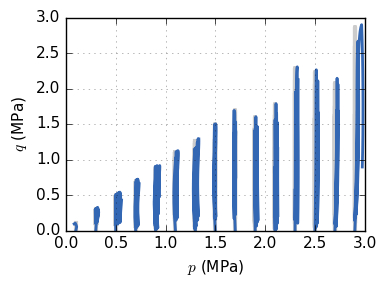

In [22]:
# Create a figure for the plot
fig = plt.figure(dpi=100, figsize=(4, 3.), tight_layout=True)

# Create a subplot
ax = fig.subplots(1)

# Plot reference stress points
for i in np.arange(sigma.shape[1]):
    ax.plot(y[:, i, 0].cpu().detach() / 1e+3, y[:, i, 1].cpu().detach() / 1e+3,
            marker='o', markerfacecolor='white', linestyle='-',
            color='black', alpha=0.2, linewidth=3, markersize=0, label='ref')

# Plot predicted stress points
for i in np.arange(pred_stress.shape[1]):
    ax.plot(pred_stress[:, i, 0] / 1e+3, pred_stress[:, i, 1] / 1e+3, alpha=1, linewidth=2, color=colorb,
            markersize=0, markeredgewidth=0.0, marker='.')

# Set labels and grid
ax.set_ylabel('$q$ (MPa)')
ax.set_xlabel('$p$ (MPa)')
ax.grid()
plt.show()

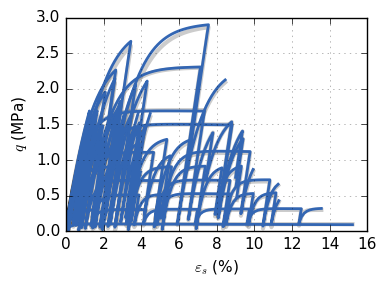

In [23]:
# Create a figure for the plot
fig = plt.figure(dpi=100, figsize=(4, 3.), tight_layout=True)

# Create a subplot
ax = fig.subplots(1)

# Plot reference stress points against strain
for i in np.arange(sigma.shape[1]):
    ax.plot(strain_t[:, i, 1] * 1e+5, y[:, i, 1].cpu().detach() / 1e+3,
            marker='o', markerfacecolor='white', linestyle='-',
            color='black', alpha=0.2, linewidth=3, markersize=0, label='ref')

# Plot predicted stress points against strain
for i in np.arange(pred_stress.shape[1]):
    ax.plot(strain_t[:, i, 1] * 1e+5, pred_stress[:, i, 1] / 1e+3, alpha=1, linewidth=2, color=colorb,
            markersize=0, markeredgewidth=0.0, marker='.')

# Set labels and grid
ax.set_ylabel('$q$ (MPa)')
ax.set_xlabel('$\\varepsilon_s$ (%)')
ax.grid()
plt.show()

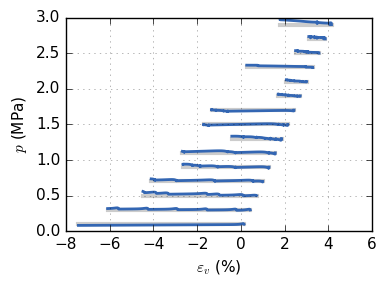

In [24]:
# Create a figure for the plot
fig = plt.figure(dpi=100, figsize=(4, 3.), tight_layout=True)

# Create a subplot
ax = fig.subplots(1)

# Plot reference stress points against volumetric strain
for i in np.arange(sigma.shape[1]):
    ax.plot(strain_t[:, i, 0] * 1e+5, y[:, i, 0].cpu().detach() / 1e+3,
            marker='o', markerfacecolor='white', linestyle='-',
            color='black', alpha=0.2, linewidth=3, markersize=0, label='ref')

# Plot predicted stress points against volumetric strain
for i in np.arange(pred_stress.shape[1]):
    ax.plot(strain_t[:, i, 0] * 1e+5, pred_stress[:, i, 0] / 1e+3, alpha=1, linewidth=2, color=colorb,
            markersize=0, markeredgewidth=0.0, marker='.')

# Set labels and grid
ax.set_ylabel('$p$ (MPa)')
ax.set_xlabel('$\\varepsilon_v$ (%)')
ax.grid()
plt.show()

### 6. Save model

In [25]:
# Define the path for saving the NICE network state dictionary
PATH = './saved/[state]NICE_benchmark1'

# Save the state dictionary of the NICE network
torch.save(NICE_network.state_dict(), PATH)

In [26]:
# Define the path for saving the normalization parameters
params_path = './saved/[params]NICE_benchmark1'

# Save the normalization parameters using pickle
with open(params_path, 'wb') as f_obj:
    pickle.dump(norm_params, f_obj)